In [409]:
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

In [410]:
class Regression:
    
    def __init__(self, feat_dims, output_classes, alpha):
        # alpha is weight decay hyperparameter
        
        self.learning_rate = 0.00000001
        self.epochs = 10
        self.batch_size = 8
        
        self.feat_dims = feat_dims
        self.output_classes = output_classes
        
        # create weights array/matrix size (num features x output)
        self.weights = 0.0001 * np.random.rand(self.feat_dims, self.output_classes)
        self.alpha = alpha  # regularization strength
        
        self.y_mean = None
        
    def normalize_feat(self, x, mean=None, std=None):
        # normalize the feature data.  test data must pass mean and std

#         print('x before single ', x[0])
        
        if mean is None:
            mean = np.mean(x, axis=0)
            
        if std is None:
            std = np.std(x, axis=0)
        
        # sub the mean per column
        x -= mean

        # div by the standard dev.
        x /= std
        
#         print('x after single ', x[0])

        return x, mean, std
        
    def load_data(self, fname, bias=1):
        
        data = loadtxt(fname, delimiter=',')
        
        # loads data, normalizes, and appends a bias vector to the data

        TRAIN_NUM = 463714  # training data up to this point

        # process training data
        x_train = data[:TRAIN_NUM,1:].astype(float)  # parse train
        x_train, train_mean, train_std = self.normalize_feat(x_train)  # normalize data

        # create a col vector of ones
        col_bias = np.ones((x_train.shape[0], bias))

        # append bias with hstack
        x_train = np.hstack((x_train, col_bias))
        
        # convert label vals to int and to vector
        y_train = data[:TRAIN_NUM,0].astype(int)
        y_train = y_train.reshape((-1, 1))

        # -------------------
        
        # process test data
        x_test = data[TRAIN_NUM:,1:].astype(float)  # parse test
        x_test, _, _ = self.normalize_feat(x_test, train_mean, train_std)  # normalize data

        # create a col vector of ones
        col_bias = np.ones((x_test.shape[0], bias))

        # append bias with hstack
        x_test = np.hstack((x_test, col_bias))    

        # convert label vals to int and to vector
        y_test = data[TRAIN_NUM:,0].astype(int)
        y_test = y_test.reshape((-1, 1))  # convert to column vector
#         print('y test single', y_test[0])

        return x_train, y_train, x_test, y_test

    def musicMSE(self, pred, gt):

        # make sure to floor by converting to int()
        diff = pred.astype(int) - gt
        mse = (np.square(diff)).mean()

        return mse
    
    def label_sub_mean(self, label):
        
        # find the mean
        self.y_mean = np.mean(label)
        
        # sub mean
        label -= self.y_mean
        
        return label
    
    def label_add_mean(self, label):
        
        label += self.y_mean
        
        return label
    
    def train_loss(self, x, yt):
        # calc the cost
        # yt = true label, sub mean label
        
        n_samples = x.shape[0]        
        pred_y = np.dot(x, self.weights)
        residual = np.square(pred_y - yt) 
        sq_residual = np.linalg.norm(residual)
        
        loss = sq_residual + self.alpha + np.square( np.linalg.norm(self.weights) )
    
        return loss / n_samples
    
    def test_loss(self, x, yt):
        # calc the cost at test time
        # yt = true label, is regular label 
        
        n_samples = x.shape[0]        
        pred_y = np.dot(x, self.weights)
        
        # need to add the y mean back
        pred_y += self.y_mean
        
        residual = np.square(pred_y - yt) 
        sq_residual = np.linalg.norm(residual)
        
        loss = sq_residual + self.alpha + np.square( np.linalg.norm(self.weights) )
    
        return loss / n_samples
    
    def gradient(self, x, yt_sm):
        
        n_samples = x.shape[0]
        
        pred_y = np.dot(x, self.weights)
        residual = np.square(pred_y - yt_sm) 
        dW = np.dot(x.T, residual) + 2 * self.weights * self.alpha
        
        return dW / n_samples

#     def calc_accuracy(self, x, y):
#         #  predict the class, then compare with the correct label.  return the average correct %
#         preds = np.argmax(x.dot(self.weights), 1)  # get prediction
# #         pred = pred.reshape((-1, 1))  # convert to column vector
        
# #         correct_count = np.equal(y, preds).sum()
#         avg = np.mean(np.equal(y, preds))
        
#         return avg, preds   # return average over all the 1's (over the total)

    def train_phase(self, x_train, y_train_sm):
        # shuffle data together, and forward prop by batch size, and add momentum

        num_train = x_train.shape[0]
        losses = []
        # Randomize the data (using sklearn shuffle)
        x_train, y_train_sm = shuffle(x_train, y_train_sm)

        # get the next batch (loop through number of training samples, step by batch size)
        for i in range(0, num_train, self.batch_size):

            # grab the next batch size
            x_train_batch = x_train[i:i + self.batch_size]
            y_train_batch_sm = y_train_sm[i:i + self.batch_size]

            # calc loss
            loss = self.train_loss(x_train_batch, y_train_batch_sm)
            
            # calc gradient (dont forget the regularization !)
            
            # ----------- need to add regularization!!! -------------
            dW = self.gradient(x_train_batch, y_train_batch_sm)
            
            self.weights -= dW * self.learning_rate  # update the weights
            losses.append(loss)  # save the losses

        return np.average(losses)  # return the average

    def test_phase(self, x, y):
        # extra, but more explicit calc of loss and gradient during testing (no back prop)
        # x is small, but y is large
        
        # calc loss
        loss = self.test_loss(x, y)
        
        return loss
        
    def run_epochs(self, x_train, y_train_sm, x_test, y_test_sm):
        # start the training/valid by looping through epochs

        # store losses and accuracies here
        train_losses = []
        test_losses = []
        train_acc_arr = []
        test_acc_arr = []

        for e in range(self.epochs): # loop through epochs

            print('Ephoch {} / {}...'.format(e + 1, self.epochs))
            
            print('weights: ', self.weights)

            # calc loss and accuracies
            train_loss = self.train_phase(x_train, y_train_sm)
            
            # need to add the mean back to label
            y_test = y_test_sm + self.y_mean
#             print('y test', y_test)
            
            test_loss = self.test_phase(x_test, y_test)
            
            print('train_loss: ', train_loss)
#             train_acc, train_preds = self.calc_accuracy(x_train, y_train)
#             test_acc, test_preds = self.calc_accuracy(x_test, y_test)

            # append vals to lists
            train_losses.append(train_loss)
            test_losses.append(test_loss)
#             train_acc_arr.append(train_acc)
#             test_acc_arr.append(test_acc)
        
        return train_losses, test_losses

#         return train_losses, test_losses, train_acc_arr, test_acc_arr, test_preds  # return all the vals


    def plot_graph(self, train_losses, test_losses, train_acc, test_acc):
        # plot graph
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label="Train loss")
        plt.plot(test_losses, label="Test loss")
        plt.legend(loc='best')
        plt.title("Epochs vs. Loss")
        plt.xlabel("Iterations")
        plt.ylabel("Loss (Cross entropy)")

        plt.subplot(1, 2, 2)
        plt.plot(train_acc, label="Train Accuracy")
        plt.plot(test_acc, label="Test Accuracy")
        # plt.legend(loc='best')
        plt.title("Epochs vs Accuracy")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.show()

    def make_mesh_grid(self, x, y, h=0.02):
        # make a mesh grid for the decision boundary
        
        x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
        y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
        x_x, y_y = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        return x_x, y_y  # matrix of x-axis and y-axis

    def plot_contours(self, plt, x_x, y_y, **params):
        # plot contours    

        array = np.array([x_x.ravel(), y_y.ravel()])
        f = np.dot(array.T, self.weights)
        prob = self.softmax(f)
        Q = np.argmax(prob, axis=1) + 1
        Q = Q.reshape(x_x.shape)
        plt.contourf(x_x, y_y, Q, **params)  # takes in variable number of params

    def plot_decision_boundary(self, x, y):
        # plot decision boundary

        markers = ('o', '.', 'x')
        colors = ('yellow', 'grey', 'green')
        cmap = ListedColormap(colors[:len(np.unique(y))])
        x_x, y_y = self.make_mesh_grid(x, y)
        self.plot_contours(plt, x_x, y_y, cmap=plt.cm.coolwarm, alpha=0.8)
        
        # plot training points
        for idx, cl in enumerate(np.unique(y)):
            xBasedOnLabel = x[np.where(y[:,0] == cl)]
            plt.scatter(x=xBasedOnLabel[:, 0], y=xBasedOnLabel[:, 1], c=cmap(idx),
                        cmap=plt.cm.coolwarm, marker=markers[idx], label=cl)
        plt.xlim(x_x.min(), x_x.max())
        plt.ylim(y_y.min(), y_y.max())
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.title("Decision Boundary - Softmax Classifier")
        plt.legend(loc='upper left')
        plt.show()


In [411]:
# create Regression() object

feat_dims = x_train.shape[1]
output_classes = 1
alpha = 0.01  # regularization

regr = Regression(feat_dims, output_classes, alpha)

In [412]:
# load the data
fname = 'YearPredictionMSD.txt'
x_train, y_train, x_test, y_test = regr.load_data(fname)

In [413]:
# discuss the properties of the data
x_min = np.min(x_train)
x_max = np.max(x_train)

y_min = np.min(y_train)
y_max = np.max(y_train)


# the range of the x feature values is huge, we from -14,000 to 65,000, with a wide
# range in scales too, from 1000s to decimals, so we'll need to normalize

# for the y labels, it's in years, from 1922-2011, and roughly the same in the test,
# though slightly wider range.

# The 90's and 2000's are much more over represented than the rest of the 
# years, expecially the earlier you get.

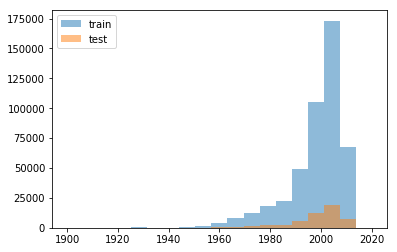

In [414]:
bins = np.linspace(1900, 2020, 20)

plt.hist(y_train, bins, alpha=0.5, label='train')
plt.hist(y_test, bins, alpha=0.5, label='test')
plt.legend(loc='upper left')
plt.show()

In [415]:
#  find the most common year (in test data)

years_arr, count = np.unique(y_test, return_counts=True)
year_count_dict = dict(zip(years_arr, count))
# year_count_dict

In [416]:
# find the loss if every prediction is most commmon 
n_samples = x_train.shape[0]
most_common_year = 2007
common_pred = np.full((n_samples, 1), most_common_year)

In [417]:
most_common_loss = musicMSE(common_pred, y_train)
most_common_loss
#  most common year loss = 193.87

193.87802179791854

In [418]:
# find loss for 1998
n_samples = x_train.shape[0]
most_common_year = 1998
common_pred = np.full((n_samples, 1), most_common_year)


In [419]:
loss_1998 = musicMSE(common_pred, y_train)
loss_1998
#  1998 year loss = 119.82

119.82739576549339

In [420]:
# Ridge Regression

# convert labels to floats
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# sub mean from y labels
y_train_sm = regr.label_sub_mean(y_train)
y_test_sm = regr.label_sub_mean(y_test)

# print('y train', y_train)
# print('y sub mean: ', y_train_sm)

train_losses, test_losses = regr.run_epochs(x_train, y_train_sm, x_test, y_test_sm)



Ephoch 1 / 10...
weights:  [[5.64085836e-05]
 [5.43956708e-05]
 [4.08304910e-05]
 [8.05364412e-05]
 [6.22838722e-05]
 [2.46665378e-05]
 [7.07336030e-05]
 [4.37469610e-05]
 [2.07208400e-05]
 [7.00375205e-05]
 [4.02614339e-05]
 [1.01898867e-05]
 [5.32683254e-05]
 [1.71556614e-07]
 [3.96413607e-05]
 [5.00028555e-05]
 [7.98410740e-05]
 [1.45467687e-06]
 [6.69261035e-05]
 [8.35675975e-05]
 [5.84156437e-05]
 [1.35057636e-05]
 [4.03385721e-05]
 [6.81794892e-05]
 [1.80053012e-05]
 [3.53157708e-05]
 [8.18875876e-06]
 [6.66997849e-05]
 [4.29967696e-05]
 [3.58261352e-05]
 [5.30675169e-05]
 [8.13379739e-05]
 [5.50233051e-06]
 [7.81026323e-05]
 [1.12540190e-05]
 [1.32280809e-05]
 [9.10827311e-05]
 [9.29470314e-05]
 [8.92211543e-05]
 [3.12397905e-05]
 [5.12767444e-05]
 [7.61792782e-05]
 [9.70888215e-05]
 [9.70143228e-05]
 [7.58113788e-05]
 [3.49983696e-05]
 [8.88521833e-05]
 [4.61189604e-06]
 [8.72954406e-05]
 [4.33173949e-05]
 [5.68123572e-06]
 [5.97105265e-05]
 [2.37078477e-05]
 [6.00205862e-05]
 

train_loss:  72.28624198364281
Ephoch 6 / 10...
weights:  [[ 1.05934240e-01]
 [ 7.56421322e-02]
 [-8.49275011e-02]
 [ 9.00238124e-03]
 [-3.51323231e-03]
 [-1.20768699e-01]
 [ 6.99082697e-02]
 [-2.37428134e-02]
 [-4.89311191e-03]
 [ 2.92306419e-02]
 [ 3.66273833e-02]
 [-6.28520901e-02]
 [ 1.27432368e-02]
 [ 1.03766972e-02]
 [-2.46629650e-02]
 [-1.71459329e-02]
 [ 2.89255506e-03]
 [-9.21016117e-03]
 [-2.43973945e-02]
 [ 1.52155285e-02]
 [-5.64922808e-02]
 [-5.46749442e-03]
 [-4.42130636e-03]
 [-4.75823383e-02]
 [ 1.80139211e-02]
 [-1.96718318e-02]
 [-9.18434969e-03]
 [ 1.09839494e-02]
 [ 5.10155322e-02]
 [-3.84622594e-03]
 [-3.49579692e-02]
 [ 9.27417731e-03]
 [-3.78270210e-02]
 [ 1.08666229e-02]
 [-5.84702491e-03]
 [-7.01108140e-02]
 [-1.06683958e-02]
 [ 3.90162048e-02]
 [ 5.23704904e-02]
 [-8.08172855e-02]
 [ 1.21076761e-03]
 [ 1.36525838e-02]
 [ 1.13888958e-02]
 [ 1.86806350e-02]
 [-5.05197572e-04]
 [-5.02997156e-02]
 [ 6.02960727e-02]
 [-4.74456136e-02]
 [ 4.61081803e-03]
 [-1.961146

train_loss:  69.74976015198959


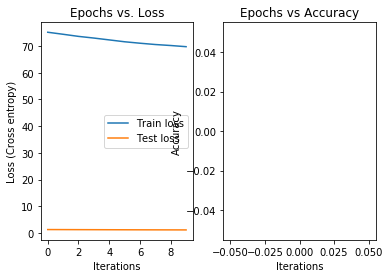

In [421]:
# plot loss and accuracies graphs

train_acc = []
test_acc = []

regr.plot_graph(train_losses, test_losses, train_acc, test_acc)

In [423]:
test_losses

[1.3117252579855223,
 1.2946501375338284,
 1.2782092973259367,
 1.2623655710125787,
 1.2470840123638094,
 1.2323436716697607,
 1.218133552338865,
 1.2044521285941718,
 1.191305111579886,
 1.178724124704276]